In [1]:
# Cellule 1 : imports & config
RANDOM_STATE = 42

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay
)
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.inspection import permutation_importance

import lightgbm as lgb
import joblib
pd.set_option("display.max_columns", None)

print("OK imports.")


OK imports.


In [2]:
# Cellule 2 : chargement du CSV
df = pd.read_csv("nhanes_ready.csv")
print(df.shape)
df.head(3)


(6889, 38)


,SEQN,RIDAGEYR,RIAGENDR,LBXTC,BMXHT,BMXBMI,BMXWT,BMXWAIST,BMXARMC,PAD680,SLD012,DRKCAL,DRPROT,DRSUGR,DRFIBE,DRTFAT,DRTALCO,DRCARB,DRWATER,smoker,diabetes,PAD680_log,DRTALCO_log,DRWATER_log,DRSUGR_log,DRFIBE_log,DRCARB_log,DRPROT_log,DRTFAT_log,DRKCAL_log,BMXBMI_log,ethnicity_MexicanAmerican,ethnicity_NonHispanicAsian,ethnicity_NonHispanicBlack,ethnicity_NonHispanicWhite,ethnicity_OtherHispanic,ethnicity_OtherRace,chol_high
0,130378.0,43.0,1,264.0,179.5,27.0,86.9,98.3,35.7,360.0,9.5,1390.0,88.525,22.060,5.95,47.420,2.280000e+01,109.785,1020.0,1,0,5.888878,3.169686e+00,6.928538,3.138100,1.938742,4.707591,4.494518,3.879913,7.237778,3.332205,False,True,False,False,False,False,1
1,130379.0,66.0,1,214.0,174.2,33.5,101.8,114.7,33.7,480.0,9.0,2484.5,82.620,113.495,24.15,73.190,6.030000e+01,280.440,120.0,1,0,6.175867,4.115780e+00,4.795791,4.740531,3.224858,5.639919,4.426283,4.306629,7.818229,3.540959,False,False,False,True,False,False,0
2,130380.0,44.0,2,187.0,152.9,29.7,69.4,93.5,36.3,240.0,8.0,1735.0,67.115,110.920,21.40,55.685,5.397605e-79,245.325,1747.5,0,1,5.484797,5.397605e-79,7.466514,4.717784,3.109061,5.506652,4.221197,4.037510,7.459339,3.424263,False,False,False,False,True,False,0


In [3]:
# Cellule 3 : check NaN / doublons / cible
print("NaN totaux :", df.isna().sum().sum())
print("Doublons   :", df.duplicated().sum())

target = "diabetes"   # <-- NOUVELLE CIBLE
assert target in df.columns, "Colonne 'diabetes' absente du CSV."
print(df[target].value_counts(dropna=False))
print((df[target].value_counts(normalize=True)*100).round(2))


NaN totaux : 0
Doublons   : 0
diabetes
0    6115
1     774
Name: count, dtype: int64
diabetes
0    88.76
1    11.24
Name: proportion, dtype: float64


In [4]:
# Cellule 4 — Définition des features

USE_ETHNICITY = True
target = "diabetes"

core = ["RIDAGEYR", "RIAGENDR", "smoker"]
morpho = ["BMXBMI_log", "BMXWAIST"]
lifestyle = ["PAD680_log", "SLD012"]
diet = ["DRKCAL_log", "DRPROT_log", "DRSUGR_log", "DRFIBE_log", "DRTFAT_log", 
        "DRCARB_log", "DRTALCO_log", "DRWATER_log" ]

ethn = [
    "ethnicity_MexicanAmerican", "ethnicity_OtherHispanic",
    "ethnicity_NonHispanicWhite", "ethnicity_NonHispanicBlack",
    "ethnicity_NonHispanicAsian", "ethnicity_OtherRace"
]

if USE_ETHNICITY:
    candidate_feats = core + morpho + lifestyle + diet + ethn
else:
    candidate_feats = core + morpho + lifestyle + diet

features = [c for c in candidate_feats if c in df.columns]
missing = [c for c in candidate_feats if c not in df.columns]
if missing:
    print("Colonnes absentes (ignorées) :", missing)

X_full = df[features].copy()
y = df[target].astype(int)
print(f"X_full : {X_full.shape} | y pos rate : {y.mean():.3f}")


X_full : (6889, 21) | y pos rate : 0.112


In [5]:
# Cellule 5 — Corrélation

import seaborn as sns

df_corr = df.copy()

# Matrice de corrélation de Pearson
corr = df_corr.corr(method="pearson").round(3)
print("=== Matrice de corrélation (Pearson) ===")
display(corr)

# Corrélation spécifique avec le diabète
print("\nCorrélations avec 'diabetes' :")
print(corr["diabetes"].sort_values(ascending=False))


=== Matrice de corrélation (Pearson) ===


,SEQN,RIDAGEYR,RIAGENDR,LBXTC,BMXHT,BMXBMI,BMXWT,BMXWAIST,BMXARMC,PAD680,SLD012,DRKCAL,DRPROT,DRSUGR,DRFIBE,DRTFAT,DRTALCO,DRCARB,DRWATER,smoker,diabetes,PAD680_log,DRTALCO_log,DRWATER_log,DRSUGR_log,DRFIBE_log,DRCARB_log,DRPROT_log,DRTFAT_log,DRKCAL_log,BMXBMI_log,ethnicity_MexicanAmerican,ethnicity_NonHispanicAsian,ethnicity_NonHispanicBlack,ethnicity_NonHispanicWhite,ethnicity_OtherHispanic,ethnicity_OtherRace,chol_high
SEQN,1.000,0.015,0.034,0.008,-0.012,-0.004,-0.007,-0.004,-0.012,0.013,-0.001,-0.014,-0.006,-0.010,-0.006,-0.019,0.014,-0.013,-0.010,0.012,0.003,0.016,0.014,-0.012,-0.007,-0.007,-0.013,-0.010,-0.019,-0.013,-0.006,-0.005,-0.002,-0.020,0.028,-0.010,-0.009,0.028
RIDAGEYR,0.015,1.000,0.007,0.222,0.233,0.277,0.295,0.446,0.276,0.054,-0.030,-0.011,0.009,-0.014,0.071,0.028,0.123,-0.069,-0.057,0.352,0.276,-0.006,0.185,-0.055,-0.024,0.059,-0.077,0.009,0.016,-0.014,0.333,-0.146,-0.033,-0.059,0.225,-0.102,-0.049,0.133
RIAGENDR,0.034,0.007,1.000,0.118,-0.468,0.064,-0.185,-0.088,-0.092,0.013,0.034,-0.274,-0.269,-0.151,-0.133,-0.212,-0.117,-0.230,-0.027,-0.096,-0.025,-0.007,-0.106,0.013,-0.135,-0.127,-0.213,-0.250,-0.188,-0.246,0.052,-0.010,0.003,0.002,0.012,0.012,-0.034,0.059
LBXTC,0.008,0.222,0.118,1.000,0.048,0.094,0.085,0.130,0.115,0.016,-0.043,-0.007,0.004,-0.037,0.018,0.007,0.099,-0.044,0.064,0.084,-0.106,-0.008,0.137,0.039,-0.040,0.020,-0.042,0.006,0.008,-0.003,0.120,-0.048,0.036,-0.076,0.079,-0.032,0.002,0.633
BMXHT,-0.012,0.233,-0.468,0.048,1.000,0.204,0.579,0.401,0.443,0.028,-0.066,0.243,0.260,0.089,0.150,0.230,0.153,0.152,0.138,0.165,0.044,0.067,0.181,0.053,0.056,0.130,0.122,0.233,0.199,0.206,0.260,-0.113,-0.082,0.015,0.161,-0.115,0.008,0.018
BMXBMI,-0.004,0.277,0.064,0.094,0.204,1.000,0.901,0.877,0.880,0.042,-0.072,-0.025,0.006,-0.031,-0.089,0.022,0.015,-0.071,0.081,0.129,0.213,0.080,0.013,0.028,-0.049,-0.096,-0.080,0.002,0.007,-0.032,0.983,-0.002,-0.135,0.067,0.040,-0.028,-0.004,0.038
BMXWT,-0.007,0.295,-0.185,0.085,0.579,0.901,1.000,0.891,0.905,0.045,-0.090,0.093,0.125,0.018,-0.009,0.125,0.078,0.016,0.124,0.167,0.193,0.102,0.085,0.043,-0.010,-0.020,-0.003,0.109,0.099,0.071,0.902,-0.052,-0.149,0.062,0.101,-0.073,0.005,0.035
BMXWAIST,-0.004,0.446,-0.088,0.130,0.401,0.877,0.891,1.000,0.856,0.056,-0.075,0.030,0.047,-0.003,-0.044,0.071,0.070,-0.032,0.065,0.229,0.255,0.088,0.082,-0.000,-0.028,-0.054,-0.046,0.040,0.048,0.016,0.900,-0.038,-0.136,0.001,0.129,-0.065,-0.008,0.067
BMXARMC,-0.012,0.276,-0.092,0.115,0.443,0.880,0.905,0.856,1.000,0.045,-0.098,0.049,0.096,-0.009,-0.037,0.088,0.056,-0.024,0.130,0.158,0.172,0.068,0.063,0.059,-0.038,-0.049,-0.043,0.079,0.061,0.028,0.903,-0.024,-0.128,0.081,0.044,-0.037,-0.000,0.043
PAD680,0.013,0.054,0.013,0.016,0.028,0.042,0.045,0.056,0.045,1.000,0.002,0.015,0.000,0.024,0.002,0.011,0.020,0.014,0.013,0.036,0.031,0.572,0.018,-0.001,0.007,-0.009,0.002,-0.007,0.001,0.001,0.043,-0.032,-0.017,0.009,0.025,-0.006,-0.001,-0.002



Corrélations avec 'diabetes' :
diabetes                      1.000
RIDAGEYR                      0.276
BMXWAIST                      0.255
BMXBMI_log                    0.215
BMXBMI                        0.213
BMXWT                         0.193
BMXARMC                       0.172
smoker                        0.134
BMXHT                         0.044
ethnicity_NonHispanicBlack    0.038
PAD680                        0.031
PAD680_log                    0.031
ethnicity_OtherRace           0.023
DRTFAT                        0.016
SEQN                          0.003
SLD012                        0.002
ethnicity_MexicanAmerican    -0.002
ethnicity_OtherHispanic      -0.004
DRPROT                       -0.006
DRTFAT_log                   -0.011
chol_high                    -0.015
DRPROT_log                   -0.016
ethnicity_NonHispanicAsian   -0.016
DRWATER                      -0.019
RIAGENDR                     -0.025
ethnicity_NonHispanicWhite   -0.026
DRKCAL                       -0.

In [6]:
# Cellule 6 — Split stratifié train / val / test

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_full, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, stratify=y_train_full, random_state=RANDOM_STATE
)

print("=== Répartition ===")
print(f"Train : {len(X_train)} | Val : {len(X_val)} | Test : {len(X_test)}")
print("Taux pos — Train/Val/Test :", round(y_train.mean(),3), round(y_val.mean(),3), round(y_test.mean(),3))


=== Répartition ===
Train : 4133 | Val : 1378 | Test : 1378
Taux pos — Train/Val/Test : 0.112 0.112 0.112


In [7]:
# Cellule 7 — Standardisation sélective

binary_cols = ["RIAGENDR", "smoker"]
if USE_ETHNICITY:
    binary_cols += [
        "ethnicity_MexicanAmerican", "ethnicity_OtherHispanic",
        "ethnicity_NonHispanicWhite", "ethnicity_NonHispanicBlack",
        "ethnicity_NonHispanicAsian", "ethnicity_OtherRace"
    ]
binary_cols = [c for c in binary_cols if c in X_train.columns]

num_cols = [c for c in X_train.columns if c not in binary_cols]
print(f"Colonnes standardisées ({len(num_cols)}) : {num_cols}")

scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val[num_cols]   = scaler.transform(X_val[num_cols])
X_test[num_cols]  = scaler.transform(X_test[num_cols])

joblib.dump(scaler, "scaler_diab.pkl")
print("Scaler sauvegardé : scaler_diab.pkl")


Colonnes standardisées (13) : ['RIDAGEYR', 'BMXBMI_log', 'BMXWAIST', 'PAD680_log', 'SLD012', 'DRKCAL_log', 'DRPROT_log', 'DRSUGR_log', 'DRFIBE_log', 'DRTFAT_log', 'DRCARB_log', 'DRTALCO_log', 'DRWATER_log']
Scaler sauvegardé : scaler_diab.pkl


In [8]:
# Cellule 8 — Entraînement du modèle LightGBM (baseline)

lgb_base = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    class_weight="balanced"
)

lgb_base.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="auc",
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=50)
    ]
)

y_val_proba = lgb_base.predict_proba(X_val)[:, 1]
print(f"AUC (validation) : {roc_auc_score(y_val, y_val_proba):.4f}")

joblib.dump(lgb_base, "model_lightgbm_diab_baseline.pkl")
print("Modèle sauvegardé : model_lightgbm_diab_baseline.pkl")


[LightGBM] [Info] Number of positive: 464, number of negative: 3669
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 4133, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.824147	valid_0's binary_logloss: 0.458997
[100]	valid_0's auc: 0.831177	valid_0's binary_logloss: 0.398055
[150]	valid_0's auc: 0.828987	valid_0's binary_logloss: 0.371336
[200]	valid_0's auc: 0.830153	valid_0's binary_logloss: 0.354792
Early stopping, best iteration is:
[103]	valid_0's auc: 0.832058	valid_0's binary_logloss: 0.395631
AUC (validation) : 0.8321
Modèle sauvegardé : model_lightgbm_diab_baseline.pkl


=== RAPPORT DE CLASSIFICATION (TEST) ===
              precision    recall  f1-score   support

           0      0.944     0.806     0.869      1223
           1      0.288     0.619     0.393       155

    accuracy                          0.785      1378
   macro avg      0.616     0.713     0.631      1378
weighted avg      0.870     0.785     0.816      1378

ROC AUC (test) : 0.8357


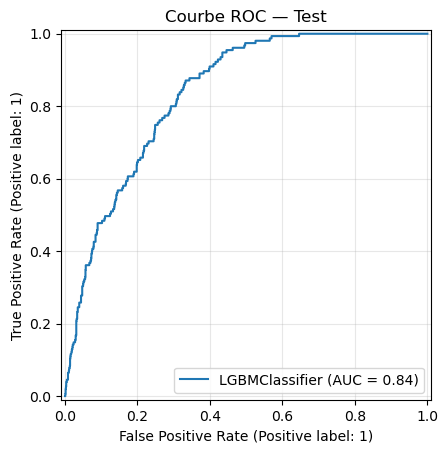

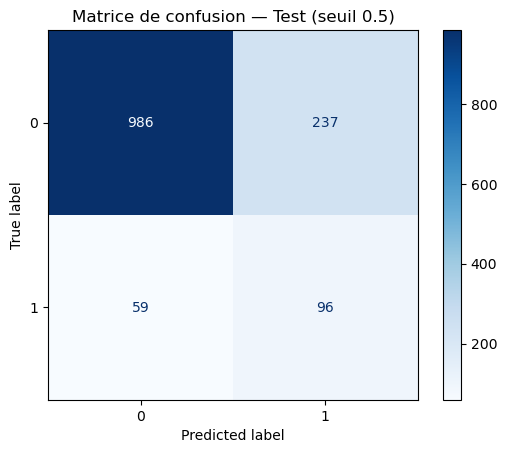

In [9]:
# Cellule 9 — Évaluation sur le jeu de test

y_test_proba = lgb_base.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= 0.5).astype(int)

print("=== RAPPORT DE CLASSIFICATION (TEST) ===")
print(classification_report(y_test, y_test_pred, digits=3))
print(f"ROC AUC (test) : {roc_auc_score(y_test, y_test_proba):.4f}")

RocCurveDisplay.from_estimator(lgb_base, X_test, y_test)
plt.title("Courbe ROC — Test")
plt.grid(alpha=0.3)
plt.show()

ConfusionMatrixDisplay.from_estimator(lgb_base, X_test, y_test, cmap="Blues")
plt.title("Matrice de confusion — Test (seuil 0.5)")
plt.grid(False)
plt.show()


=== Seuil optimal ===
Seuil : 0.639
F1 max : 0.437
Précision : 0.402
Rappel : 0.477


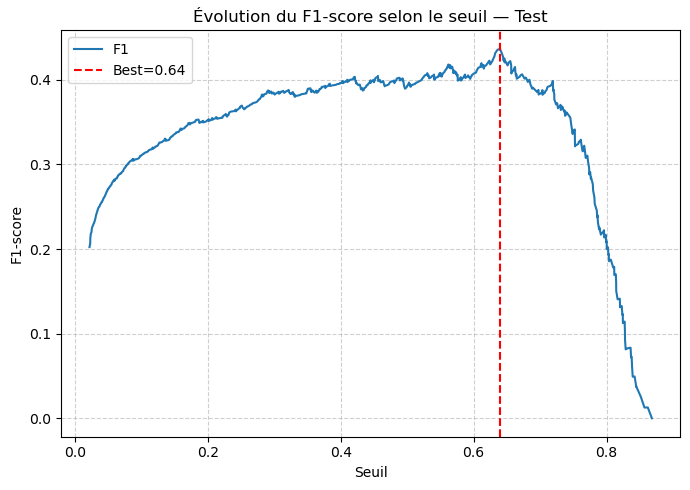

In [10]:
# Cellule 10 — Recherche du seuil optimal (max F1)

from sklearn.metrics import precision_recall_curve, f1_score

# Probabilités sur le jeu de test
y_scores = lgb_base.predict_proba(X_test)[:, 1]

# Calcul des points de la courbe précision-rappel
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# Calcul du F1 pour chaque seuil
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

# Indice du meilleur F1
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"=== Seuil optimal ===")
print(f"Seuil : {best_threshold:.3f}")
print(f"F1 max : {best_f1:.3f}")
print(f"Précision : {precisions[best_idx]:.3f}")
print(f"Rappel : {recalls[best_idx]:.3f}")

# Tracé du F1 en fonction du seuil
plt.figure(figsize=(7,5))
plt.plot(thresholds, f1_scores[:-1], label="F1")
plt.axvline(best_threshold, color="red", linestyle="--", label=f"Best={best_threshold:.2f}")
plt.title("Évolution du F1-score selon le seuil — Test")
plt.xlabel("Seuil")
plt.ylabel("F1-score")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


=== RAPPORT DE CLASSIFICATION (SEUIL 0.64) ===
              precision    recall  f1-score   support

           0      0.932     0.910     0.921      1223
           1      0.402     0.477     0.437       155

    accuracy                          0.861      1378
   macro avg      0.667     0.694     0.679      1378
weighted avg      0.873     0.861     0.866      1378

ROC AUC (test) : 0.8357


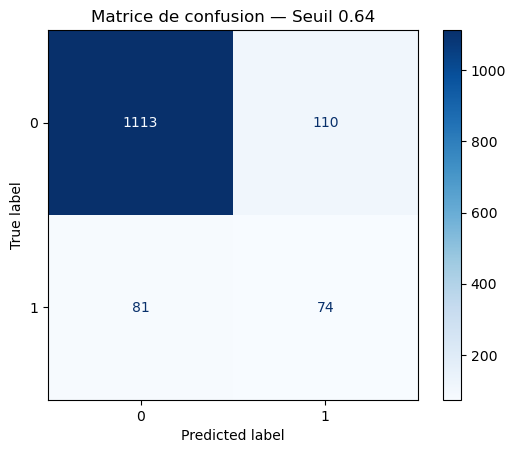

In [11]:
# Cellule 11 — Évaluation finale au seuil optimal

y_pred_opt = (y_scores >= best_threshold).astype(int)

print(f"=== RAPPORT DE CLASSIFICATION (SEUIL {best_threshold:.2f}) ===")
print(classification_report(y_test, y_pred_opt, digits=3))
print(f"ROC AUC (test) : {roc_auc_score(y_test, y_scores):.4f}")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_opt, cmap="Blues")
plt.title(f"Matrice de confusion — Seuil {best_threshold:.2f}")
plt.grid(False)
plt.show()
